# Import and Data Loading

In [19]:
import pandas as pd

Load file as Numpy Array

In [9]:
import numpy as np

In [7]:
def load_file(filepath):
    df = pd.read_csv(filepath, header = None, delim_whitespace = True)
    return df.values
data = load_file(r'C:\Users\Kanishk Verma\Desktop\Signal\Git\UCI HAR Dataset\train\Inertial Signals\total_acc_y_train.txt')
print(data.shape)

(7352, 128)


Loading files as group

In [10]:
def load_group(filenames, prefix = ''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    #dstack so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

Load total accelerometer data

In [14]:
filenames = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
total_acc = load_group(filenames, prefix = "C:\\Users\\Kanishk Verma\\Desktop\\Signal\\Git\\UCI HAR Dataset\\train\\Inertial Signals\\")
print(total_acc.shape)

(7352, 128, 3)


Load train and test dataset

In [53]:
def load_dataset(group, prefix=''):
    filepath = prefix + group + "\\Inertial Signals\\"
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [17]:
trainX, trainy = load_dataset('train', "C:\\Users\\Kanishk Verma\\Desktop\\Signal\\Git\\UCI HAR Dataset\\")
print(trainX.shape, trainy.shape)

(7352, 128, 9) (7352, 1)


In [18]:
testX, testy = load_dataset('test', "C:\\Users\\Kanishk Verma\\Desktop\\Signal\\Git\\UCI HAR Dataset\\")
print(testX.shape, testy.shape)

(2947, 128, 9) (2947, 1)


# Data Conditioning

Check balance of each activity

In [22]:
def class_breakdown(data):
    df = pd.DataFrame(data)
    #number of rows
    counts = df.groupby(0).size()
    #retrieve raw rows
    counts = counts.values
    #summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage =%.3f' %(i+1, counts[i], percent))

Training Dataset

In [23]:
class_breakdown(trainy)

Class=1, total=1226, percentage =16.676
Class=2, total=1073, percentage =14.595
Class=3, total=986, percentage =13.411
Class=4, total=1286, percentage =17.492
Class=5, total=1374, percentage =18.689
Class=6, total=1407, percentage =19.138


Test dataset

In [24]:
class_breakdown(testy)

Class=1, total=496, percentage =16.831
Class=2, total=471, percentage =15.982
Class=3, total=420, percentage =14.252
Class=4, total=491, percentage =16.661
Class=5, total=532, percentage =18.052
Class=6, total=537, percentage =18.222


Summarize as combined

In [25]:
combined = np.vstack((trainy, testy))
class_breakdown(combined)

Class=1, total=1722, percentage =16.720
Class=2, total=1544, percentage =14.992
Class=3, total=1406, percentage =13.652
Class=4, total=1777, percentage =17.254
Class=5, total=1906, percentage =18.507
Class=6, total=1944, percentage =18.876


# Visualising

Grouping data by activity

In [29]:
def data_by_activity(X, y, activities):
    return {a: X[y[:,0]==a, :, :] for a in activities}

Convert series of windows to a 1-dimension list

In [28]:
def to_series(windows):
    series = list()
    for window in windows:
        half = int(len(window)/2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

Get data for one subject

In [31]:
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

# Plotting a histogram

In [43]:
import matplotlib.pyplot as plt
def plot_activity_histograms(X,y):
    
    activity_ids = unique(y[:,0])
    
    grouped = data_by_activity(X, y, activity_ids)
    
    plt.figure()
    
    xaxis = None
    
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        
        for i in range(3):
            ax = plt.subplot(len(activity_ids), 1, k+1, sharex = xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            plt.hist(to_series(grouped[act_id][:, :,6+i]), bins=100)
            plt.title('Activity' +str(act_id), y=0, loc = 'left')
    plt.show()

In [32]:
sub_map = load_file(r"C:\Users\Kanishk Verma\Desktop\Signal\Git\UCI HAR Dataset\train\subject_train.txt")

In [33]:
sub_map

array([[ 1],
       [ 1],
       [ 1],
       ...,
       [30],
       [30],
       [30]], dtype=int64)

In [36]:
from numpy import unique
train_subjects = unique(sub_map)

In [38]:
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)

As seen below each activity has a different data distribution with first three and other three activities
First 3 activities look like Normal Distribution with varying means and standard deviations.
The activities 4,5,6 looks like multi-modal

Activity 1 - Walking;
Activity 2 - Walking Upstairs;
Activity 3 - Walking Downstairs;
Activity 4 - Sitting;
Activity 5 - Standing;
Activity 6 - Laying;

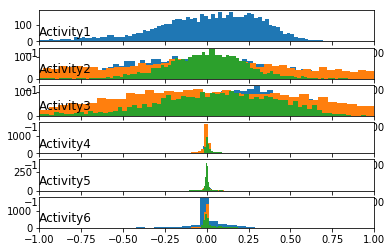

In [44]:
plot_activity_histograms(subX,suby)

# Plotting a Box plot

Plotting one box plot for each activity

In [46]:
def boxplt(X, y, sub_map):
    subject_ids = unique(sub_map[:,0])
    activity_ids = unique(y[:,0])
    
    activity_windows = {a: list() for a in activity_ids}
    
    for sub_id in subject_ids:
        _, subj_y = data_for_subject(X, y, sub_map, sub_id)
        
        for a in activity_ids:
            activity_windows[a].append(len(subj_y[subj_y[:,0]==a]))

    durations = [activity_windows[a] for a in activity_ids]
    
    plt.boxplot(durations,labels = activity_ids)
    
    plt.show()

In [56]:
X, y = load_dataset('train', "C:\\Users\\Kanishk Verma\\Desktop\\Signal\\Git\\UCI HAR Dataset\\")

As seen below, Less time is spent on motion activities  like Walking, Walking Upstairs and Downstairs.

More time is spent on stationary activities like Sitting, Standing and Laying

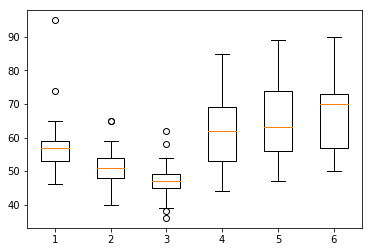

In [57]:
boxplt(X, y, sub_map)